## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
## Note: the base code is taken from class notes

import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib qt
%matplotlib inline

def CameraCalibration():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')
    #images = cv2.imread('camera_cal/calibration1.jpg')
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

    #Find the camera calibration matrix and distortion coefficients using Open CV function cv2.calibrateCamera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,imgpoints,gray.shape[::-1],None,None)
    return mtx,dist

## Applying distortion coefficient to a raw image

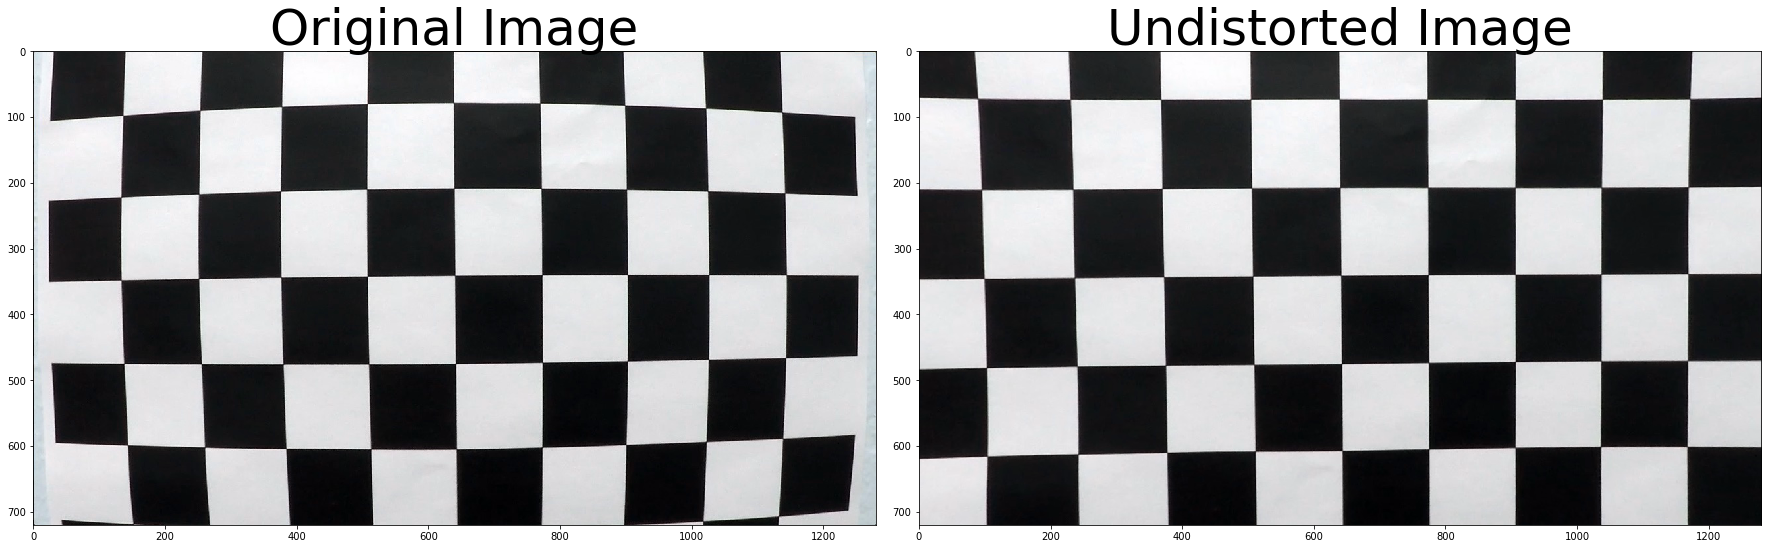

In [2]:
## Note: the base code is taken from class notes

#Applying distortion coefficient to a raw image 
img = cv2.imread('camera_cal/calibration1.jpg')
mtx,dist = CameraCalibration()
#img = cv2.imread('test_images/test1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Saving the images to directory
#mpimg.imsave("output_images/Original_distorted_Image.jpg",img)
#mpimg.imsave("output_images/Undistorted_Image.jpg",undistorted)

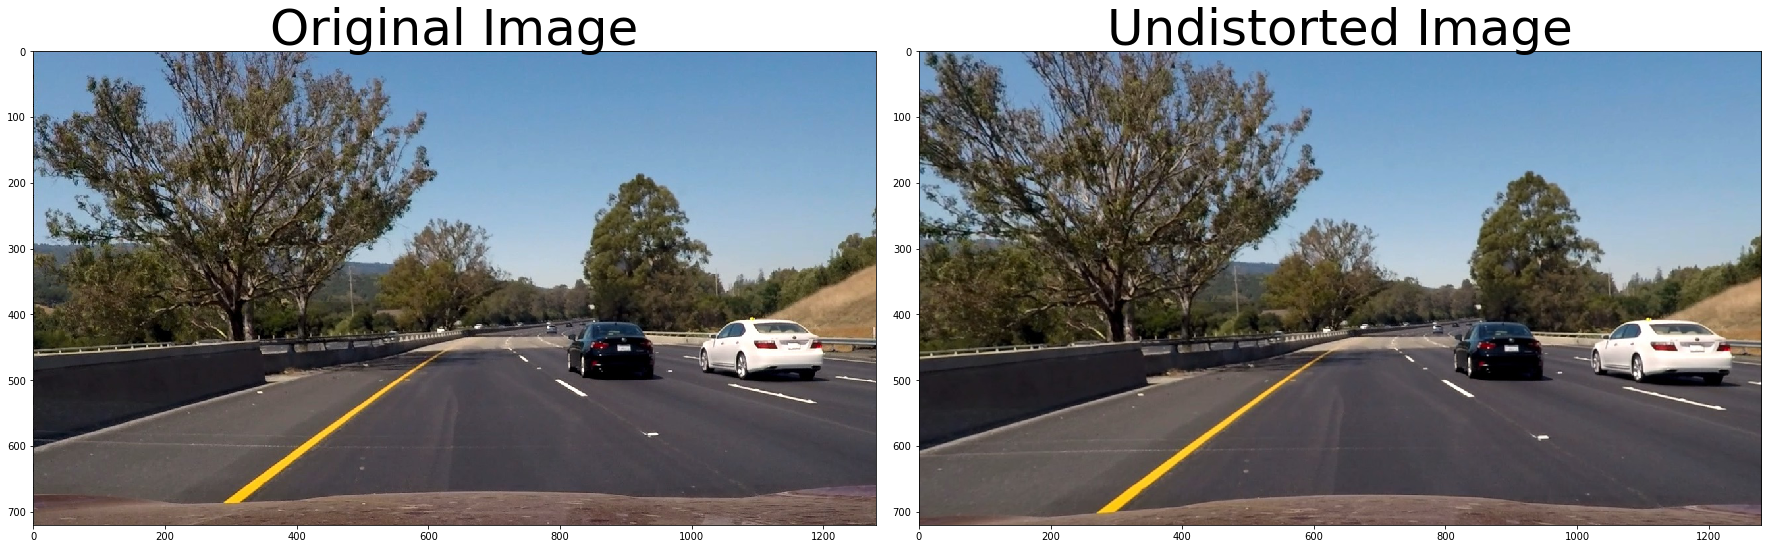

In [3]:
## Note: the base code is taken from class notes

#Applying distortion coefficient to a raw image 
img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Saving the images to directory
#mpimg.imsave("output_images/Original_Lane_distorted_Image.jpg",img)
#mpimg.imsave("output_images/Undistorted_Lane_Image.jpg",undistorted)


## Using color transforms, gradients, etc., to create a thresholded binary image

Text(0.5,1,'Resulting Binary Image')

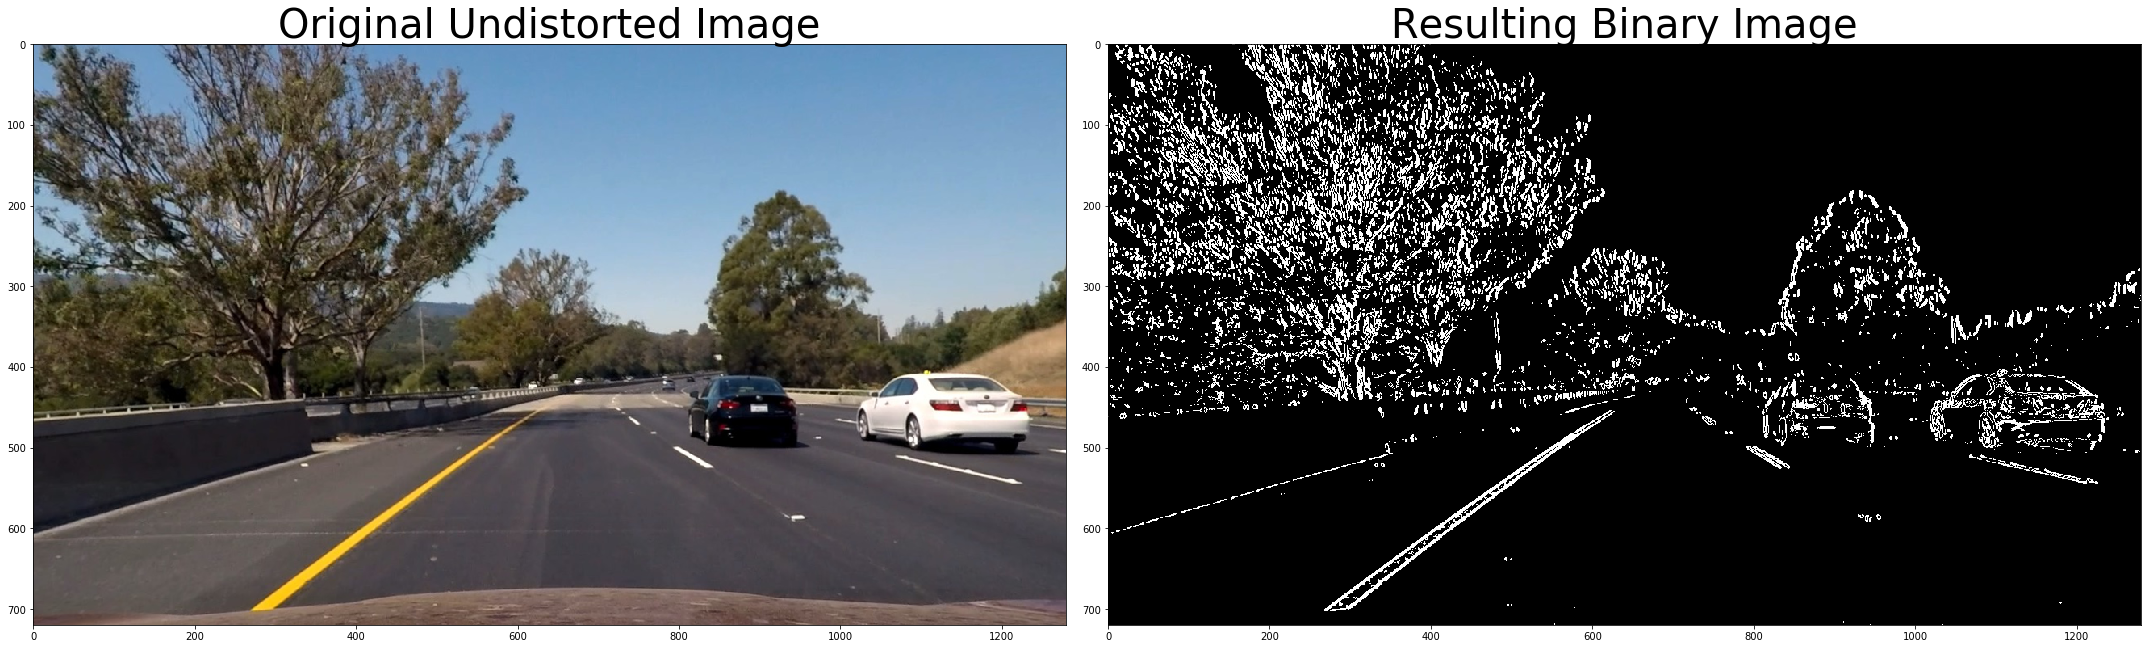

In [4]:
## Note: the base code is taken from class notes
## Defining all the thresholding functions to tryout different combinations

def rgb_to_HLS(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #Separate the HLS channels
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    return h_channel,l_channel,s_channel
    

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    #img_copy = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #h_channel,l_channel,s_channel = rgb_to_HLS(img_copy)
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
        
    sobel_abs = np.absolute(sobel)
    scaled_sobel = np.uint8(255*sobel_abs/np.max(sobel_abs))
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1
    return grad_binary

def magnitude_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    #img_copy = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #h_channel,l_channel,s_channel = rgb_to_HLS(img_copy)
    sobelx = cv2.Sobel(gray,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray,cv2.CV_64F,0,1,ksize = sobel_kernel)
    mag = np.sqrt(np.square(sobelx) + np.square(sobely))
    scaled_sobel = np.uint8(255*mag/np.max(mag))
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel>=thresh[0]) & (scaled_sobel<=thresh[1])] = 1 
    return mag_binary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    #img_copy = np.copy(img)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    #h_channel,l_channel,s_channel = rgb_to_HLS(img_copy)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize = sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely,abs_sobelx)
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction>=thresh[0]) & (direction<=thresh[1])] = 1
    return dir_binary

## By combining the above thresholds come up with a binary image
def binary_image(img):
    img_copy = np.copy(img)
    h_channel,l_channel,s_channel = rgb_to_HLS(img_copy)
    s_thresh = (160, 250) 
    #h_thresh = (20, 30)
    abs_thresh = (30, 100)
    #mag_thresh = (30, 100)
    #dir_thresh = (0, np.pi/2)
    ksize = 7
   
    # Threshold S-color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold H-color channel
    #h_binary = np.zeros_like(h_channel)
    #h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    # Sobel x binary
    sobelx_binary = abs_sobel_thresh(img_copy, orient='x', sobel_kernel=ksize, thresh=abs_thresh)
    # Magnitude binary
    #mag_binary = magnitude_thresh(img_copy, sobel_kernel=ksize, thresh=mag_thresh)
    #Direction binary
    #dir_binary = dir_threshold(img_copy, sobel_kernel=ksize, thresh=dir_thresh)


    # Stack each channel
    #color_binary = np.dstack(( np.zeros_like(s_binary), sobelx_binary,dir_binary)) * 255
    combined_binary = np.zeros_like(s_binary)
    #combined_binary[((dir_binary == 1) & (mag_binary == 1)) & (sobelx_binary == 1) | (s_binary==1)] = 1
    combined_binary[(s_binary==1) | (sobelx_binary == 1)] = 1
    return combined_binary
    

img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx ,dist, None, mtx)
result_combined = binary_image(undistorted)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
f.tight_layout()

ax1.imshow(undistorted)
ax1.set_title('Original Undistorted Image', fontsize=40)
ax2.imshow(result_combined,cmap='gray')
ax2.set_title('Resulting Binary Image', fontsize=40)

# Saving the images to directory
#mpimg.imsave("output_images/Test_image6_Undistorted.jpg",undistorted)
#mpimg.imsave("output_images/Test_image6_Binary_threshold.jpg",result_combined,cmap='gray')

## Applying a perspective transform to image ("birds-eye view")

Text(0.5,1,'Transformed image')

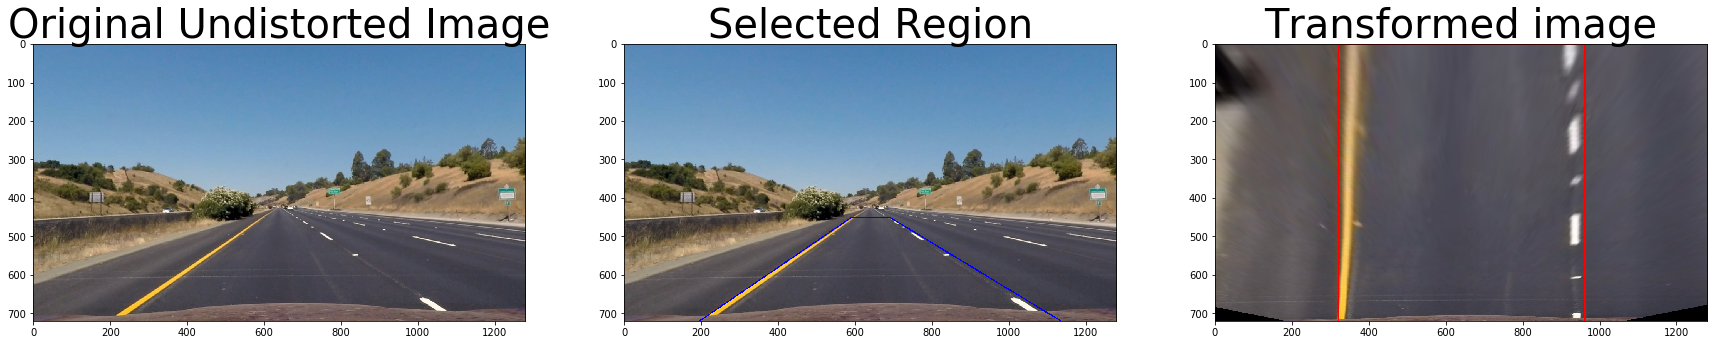

In [5]:
## Using the staright line images from the test_images folder to calculate the perspective transform
def perspective_transform(img):
    img_copy = np.copy(img)
    #Define the source image points
    src = np.float32([[195,720],[1135,720], [690,450],[590,450]])
    
    ### DRAW SELECTECD REGION FOR VISUALIZING####
    # Defining a four sided polygon to mask
    # create new image copy for displaying the region selected
    select = np.copy(img)
    imshape = select.shape
    vertices = np.array([[(195,720),(1135,720), (690,450),(590,450)]], dtype=np.int32)
    # Drawing the region selected using the vertices 
    selected_region = cv2.polylines(select, vertices, isClosed = True, color =[0, 0, 255], thickness = 2)
    
    
    offset = 320
    height = img.shape[0]
    width = img.shape[1]
    dst = np.float32([[offset,height],[width-offset,height],[width-offset,0],[offset,0]])

    
    #Get perspective transform matrix for warping image
    M = cv2.getPerspectiveTransform(src, dst)
    #Get Inverse transform matrix for unwarping image later
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    img_size = (img.shape[1],img.shape[0])
    warped = cv2.warpPerspective(img_copy, M, img_size,flags=cv2.INTER_LINEAR)
    
    dst_vertices = np.array([[(offset,height),(width-offset,height),(width-offset,0),(offset,0)]], dtype=np.int32)
    
    warped_copy = np.copy(warped)
    warped_region = cv2.polylines(warped_copy, dst_vertices, isClosed = True, color =[255, 0, 0], thickness = 2)
    
    return M, Minv,selected_region,warped,warped_region

img = mpimg.imread('test_images/straight_lines1.jpg')
img_copy = np.copy(img)
undistorted = cv2.undistort(img_copy, mtx, dist, None, mtx)
M, Minv,selected_region,warped,warped_region = perspective_transform(undistorted)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(undistorted)
ax1.set_title('Original Undistorted Image', fontsize=40)
ax2.imshow(selected_region)
ax2.set_title('Selected Region', fontsize=40)
ax3.imshow(warped_region)
ax3.set_title('Transformed image', fontsize=40)
#mpimg.imsave("output_images/straight_lines1_Undistorted.jpg",undistorted)
#mpimg.imsave("output_images/straight_lines1_selected_region.jpg",selected_region)
#mpimg.imsave("output_images/straight_lines1_warped.jpg",warped)

## Apply the perspective transform to binary image

In [6]:
## Using the cv2.fillPoly define a polygon to find the region of interest, i.e., lane lines

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [7]:
## Note: the base code is taken from class notes

def perspective_binary_processing(img):
    img_copy = np.copy(img)
    #Convert image to binary using the binary Thresholds
    result_combined = binary_image(img_copy)

    ### USE REGION SELECTION TO ELINIMATE AREAS WITH SHADOWS####
    # Defining a four sided polygon to mask
    # create new image copy for displaying the region selected
    imshape = img_copy.shape
    vertices = np.array([[(125,imshape[0]),(600,425), (imshape[1]-550, 425), (imshape[1]-130,imshape[0])]], dtype=np.int32)
    ## Mask the image based on defined region of interest
    img_masked = region_of_interest(result_combined, vertices)
    # Drawing the region selected using the vertices 
    #selection = cv2.polylines(select, vertices, isClosed = True, color =[0, 0, 255], thickness = 2)

    ## Pass the selcted region for image transformation
    #Transform the image for getting birds eye view
    M, Minv,selected_region,warped,warped_region = perspective_transform(img_masked)

    return warped, Minv

Text(0.5,1,'Transformed binary image')

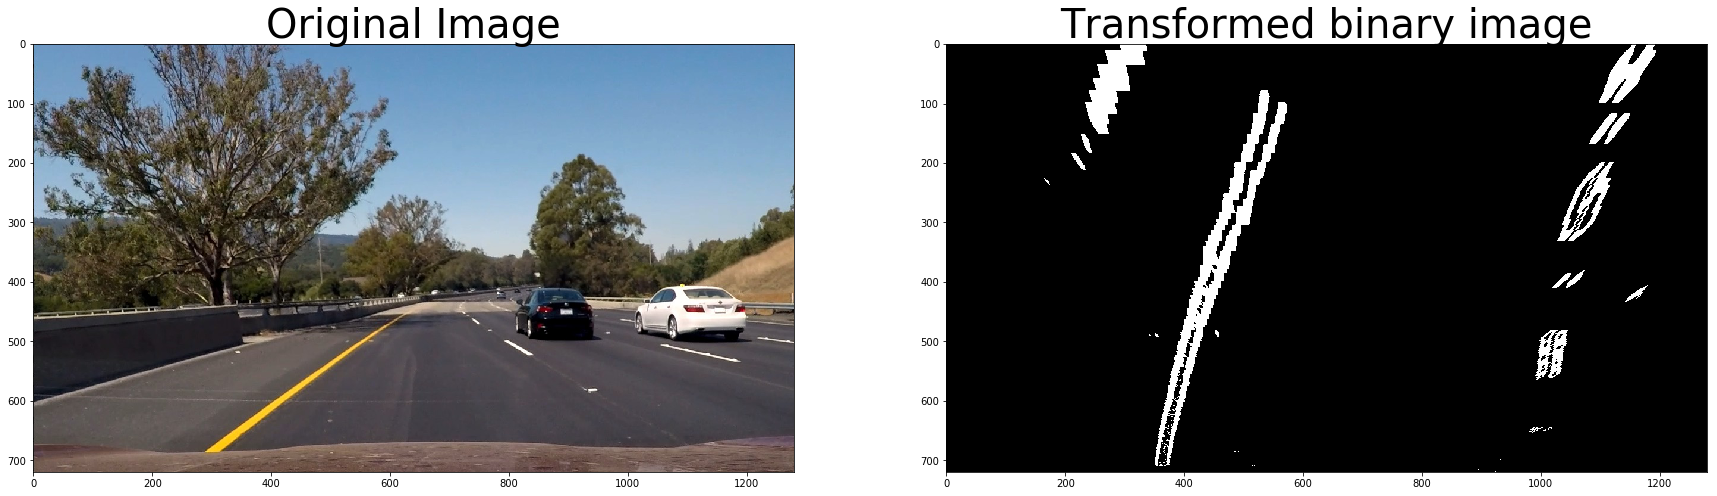

In [8]:
img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(img)[0]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Transformed binary image', fontsize=40)
# Saving the images to directory
#mpimg.imsave("output_images/Test_image6_Perspective_binary_transformed.jpg",warped,cmap='gray')

## Using Histogram and Sliding window method to find the lane lines in the Binary Image

Text(0.5,1,'Transformed binary image')

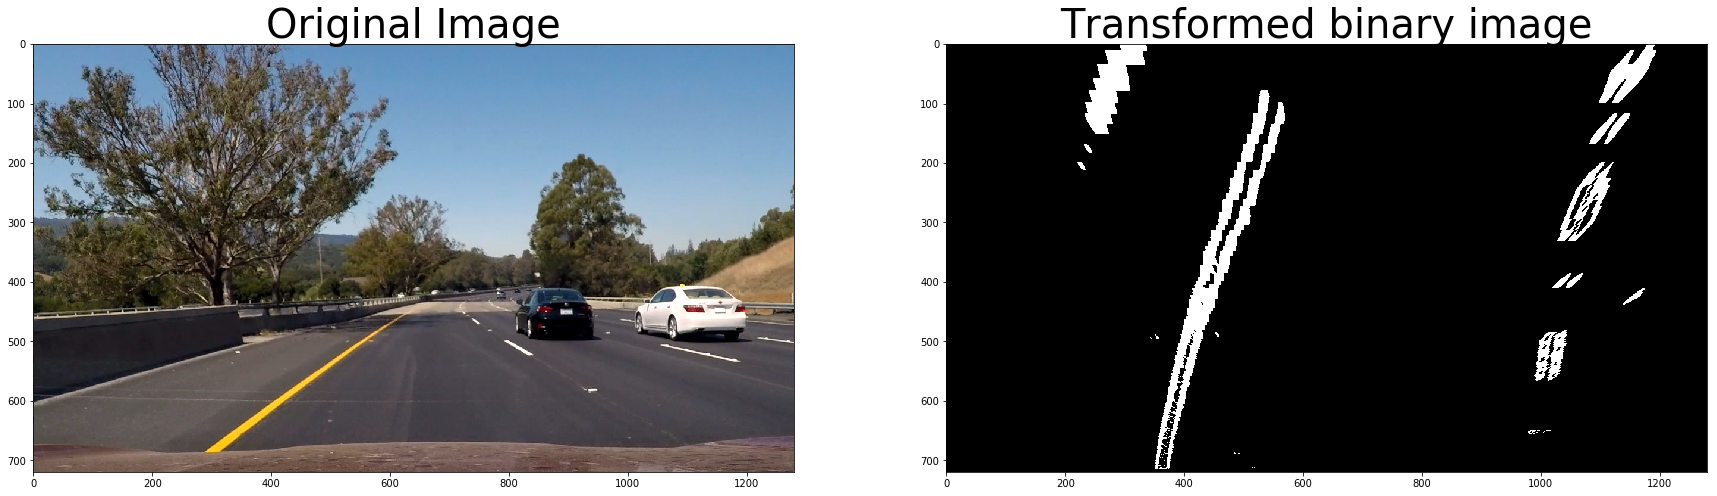

In [9]:
## Note: the base code is taken from class notes
def histo(img):
    ## Sum up the binary pixels in the bottom half of the image column-wise to identify where lane lines are
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    return histogram

img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(undistorted)[0]
histogram = histo(warped)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)
ax2.imshow(warped,cmap='gray')
ax2.set_title('Transformed binary image', fontsize=40)


In [10]:
## Note: the base code is taken from class notes

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = histo(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # WINDOW HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        
        ### Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzerox>=win_xleft_low) & (nonzerox<win_xleft_high) & (nonzeroy>=win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        good_right_inds = ((nonzerox>=win_xright_low) & (nonzerox<win_xright_high) & (nonzeroy>=win_y_low) & (nonzeroy<win_y_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if(len(good_left_inds)>minpix):
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if(len(good_right_inds)>minpix):
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped,ym_per_pix=1,xm_per_pix=1):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty*ym_per_pix,leftx*xm_per_pix,2)
    right_fit = np.polyfit(righty*ym_per_pix,rightx*xm_per_pix,2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane line

    return out_img,left_fitx,right_fitx,ploty,left_fit,right_fit

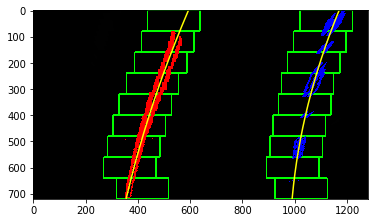

In [11]:
img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(undistorted)[0]
out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)

## Store last polynomial fit values
left_fit_last = left_fit
right_fit_last = right_fit

plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
# Saving the images to directory
#mpimg.imsave("output_images/Test_image6_Sliding_window.jpg",out_img)

## Calculate the radius of curvature

In [12]:
# Define conversions in x and y from pixels space to meters
## This will be used to get radius of curvature in values in real-world space from pixels
ym_per_pix = 30/img.shape[0] # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

In [13]:
def radius_curvature(img):
    ## Get the polynomial fits converted from pixel to real world space values
    ploty,left_fit,right_fit = fit_polynomial(img,ym_per_pix,xm_per_pix)[3:]
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the imag
    y_eval = np.max(ploty)*ym_per_pix
    
    #####Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power(1+np.square(2*left_fit[0]*y_eval+left_fit[1]),3/2)/np.absolute(2*left_fit[0])
    right_curverad = np.power(1+np.square(2*right_fit[0]*y_eval+right_fit[1]),3/2)/np.absolute(2*right_fit[0])
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(undistorted)[0]
left_curverad, right_curverad = radius_curvature(warped)

print("Left curvature: {} m, Right curvature: {} m".format(left_curverad, right_curverad))

Left curvature: 1224.6472819681228 m, Right curvature: 737.5556314113593 m


## Detect Vehicle position with respect to center

In [14]:
def dist_from_center(img,left_fit,right_fit):
    y = img.shape[0]  ##Bottom point of the image
    ## Find the x-axis values for left and right lanes at the bottom of the image
    left_fitx = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]
    right_fitx = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]
    lane_center = (right_fitx + left_fitx)/2
    
    #Center of the image
    center = img.shape[1]/2

    # Distance form center is the difference between the image center and lane center
    dist_from_center = (center - lane_center)*xm_per_pix
    
    return dist_from_center

# Calculate the vehicle position with respect to center
img = mpimg.imread('test_images/straight_lines1.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(undistorted)[0]
#Find the left lane and right lane polynominal equations to calculate the
# x-axis pixel value for the left and right lane at the bottom of the image
ploty,left_fit,right_fit = fit_polynomial(warped)[3:]
dist = dist_from_center(warped,left_fit,right_fit)

print("Centre distance: {} m".format(dist))
    

Centre distance: 0.054394546363349415 m


## Using information from previous Sliding Window to limit search region

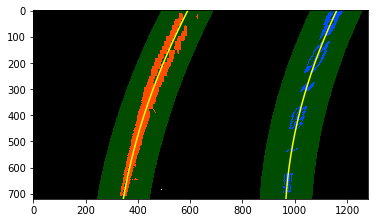

In [15]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty,leftx,2)
    right_fit = np.polyfit(righty,rightx,2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty, left_fit, right_fit

# Pass the previous polynomial fits for left and right lanes as input to the function
def search_around_poly(binary_warped,left_fit,right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    
    left_lane_inds = ((nonzerox>(left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin))
                       & (nonzerox<(left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox>(right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox<(right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty,new_left_fit, new_right_fit = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    return result,left_fitx,right_fitx,ploty,new_left_fit, new_right_fit

# Calculate the vehicle position with respect to center
img = mpimg.imread('test_images/test3.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped = perspective_binary_processing(undistorted)[0]
result,left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(warped,left_fit_last,right_fit_last)
# Plot the polynomial lines onto the image
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(result)
# Saving the images to directory
#mpimg.imsave("output_images/Test_image3_Targeted_search.jpg",result)

## Warping the detected lane boundaries back onto the original image

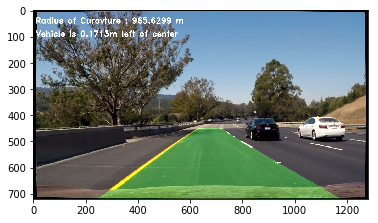

In [16]:
def warp_back(undist,warped,Minv,left_fitx,right_fitx,ploty,left_fit,right_fit,count):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    #Write Radius of Curvature and Distance from Centre
    ## REFERENCE : https://www.geeksforgeeks.org/python-opencv-cv2-puttext-method/
    
    #Defining the parameters
    org = (10, 50) 
    fontScale = 1
    font = 2
    color = (255, 255, 255)
    thickness = 2
    # Calculate the radius of curvature in meters for both lane lines       
    left_curverad, right_curverad = radius_curvature(warped)
    avg_curvature = (left_curverad+right_curverad)/2
    
    text1 = "Radius of Curavture : {} m".format(round(avg_curvature,4))
    
    #Calculate the vehicle position with respect to center   
    dist = dist_from_center(warped,left_fit,right_fit)
    if(dist>=0):
        direction = "right"
    else:
        direction = "left"
        
    text2 = "Vehicle is {}m {} of center".format(round(abs(dist),4),direction)
    
    # Using cv2.putText() method 
    image_text = cv2.putText(result, text1, org,font,fontScale, color, thickness, cv2.LINE_AA) 
   
    org = (10, 100)
    
    image_text = cv2.putText(image_text, text2, org, font,fontScale, color, thickness, cv2.LINE_AA) 

    return image_text
    
    
    
img = mpimg.imread('test_images/test6.jpg')
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
warped,Minv = perspective_binary_processing(undistorted)
out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)
result = warp_back(undistorted,warped,Minv,left_fitx,right_fitx,ploty,left_fit,right_fit,0)
plt.imshow(result)
# Saving the images to directory
#mpimg.imsave("output_images/Test_image6_Unwarped_and_Displayed.jpg",result)

## Run the Pipeline on the video

In [17]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [18]:
def pipeline_process(img):
    # Undistort the Image using the Camera Calibration Matrix calculated at the beginning
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    # Applying Binary thresholds and transform the image to get Bird's eye view
    warped,Minv = perspective_binary_processing(undistorted)
    global count
    global left_fit_prev
    global right_fit_prev
    if count == 0:
        out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = fit_polynomial(warped)
        ## Store last polynomial fit values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
    else:
        out_img,left_fitx,right_fitx,ploty,left_fit,right_fit = search_around_poly(warped,left_fit_prev,right_fit_prev)
        ## Store last polynomial fit values
        left_fit_prev = left_fit
        right_fit_prev = right_fit

    result = warp_back(undistorted,warped,Minv,left_fitx,right_fitx,ploty,left_fit,right_fit,count)
    count+=1
    return result

In [19]:
## Use counter variable identify it's the first frame in the video
## If it's the first frame then, we will use sliding window method
## For the other frames we will use Targeted search based on the polynomial fit obtained from Sliding Window
count = 0
left_fit_prev = 0
right_fit_prev = 0

In [20]:
video_output = 'project_video_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("project_video.mp4").subclip(0,2)
clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(pipeline_process) #NOTE: this function expects color images!!
%time video_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:55<00:00,  4.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 2min 30s, sys: 25.8 s, total: 2min 56s
Wall time: 4min 58s


In [21]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output))